# B2C3/B2F2 - Casus: Walking Patterns

In [49]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np
import math

import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Datasets

In [50]:
# Load datasets
df_train = pd.read_csv("../Data/TrainingData.csv")
df_val = pd.read_csv("../Data/ValidationData.csv")

# Voeg de trainings- en validatiegegevenssets samen
df = pd.concat([df_train, df_val])

In [51]:
# Definieer constanten
sig_min = -104
sig_max = 0
tar_min = 0.25
tar_max = 1.0
no_sig = 100
lat_min = 4864745.7450159714
lat_max = 4865017.3646842018
long_min = -7695.9387549299299000
long_max = -7299.786516730871000

### Exploratory Data Analysis (EDA)

In [52]:
df_train.shape
df_val.shape

# Geef de eerste paar rijen van de gegevensset weer
df_train.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [53]:
df_train.columns

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)

In [54]:
df = pd.concat([df_train, df_val])
df.iloc[:,-9:]

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,-7541.264300,4.864921e+06,2,1,106,2,2,23,1371713733
1,-7536.621200,4.864934e+06,2,1,106,2,2,23,1371713691
2,-7519.152400,4.864950e+06,2,1,103,2,2,23,1371714095
3,-7524.570400,4.864934e+06,2,1,102,2,2,23,1371713807
4,-7632.143600,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...
1106,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


In [55]:
# Geef samenvattende statistieken van de dataset weer
print("statistieken van de dataset:")
print(df.describe())

# Geef het aantal unieke gebruikers en telefoons weer
print(f"Aantal unieke gebruikers: {df['USERID'].nunique()}\n")
print(f"aantal unieke telefoons: {df['PHONEID'].nunique()}\n")

# Geef unieke gebruikers- en telefoon-ID's weer
print(f"Aantal unieke gebruikers: {df['USERID'].unique()}\n")
print(f"Aantal unieke telefoons: {df['PHONEID'].unique()}\n")

# Toon vermeldingen per gebruiker en telefoon
print(f"Entries per gebruiker:\n{df['USERID'].value_counts()}\n")
print(f"Entries per telefoon:\n{df['PHONEID'].value_counts()}\n")


statistieken van de dataset:
             WAP001        WAP002        WAP003        WAP004        WAP005  \
count  21048.000000  21048.000000  21048.000000  21048.000000  21048.000000   
mean      99.760500     99.830388     99.982326     99.982326     99.634122   
std        6.811116      5.643191      1.813086      1.813165      8.385624   
min      -97.000000    -90.000000    -87.000000    -88.000000    -97.000000   
25%      100.000000    100.000000    100.000000    100.000000    100.000000   
50%      100.000000    100.000000    100.000000    100.000000    100.000000   
75%      100.000000    100.000000    100.000000    100.000000    100.000000   
max      100.000000    100.000000    100.000000    100.000000    100.000000   

             WAP006        WAP007        WAP008        WAP009        WAP010  \
count  21048.000000  21048.000000  21048.000000  21048.000000  21048.000000   
mean      97.281927     95.011640     93.845401     94.480758     99.145192   
std       22.327658   

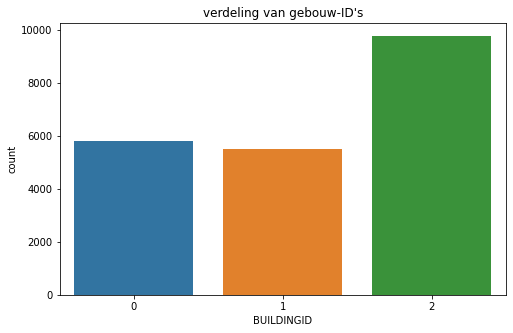

In [56]:
# Teken de verdeling van gebouw-ID's
plt.figure(figsize=(8, 5))
sns.countplot(x='BUILDINGID', data=df)
plt.title("verdeling van gebouw-ID's")
plt.show()

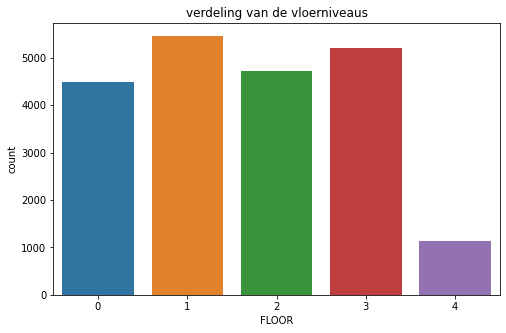

In [57]:
# Teken de verdeling van de vloerniveaus
plt.figure(figsize=(8, 5))
sns.countplot(x='FLOOR', data=df)
plt.title("verdeling van de vloerniveaus")
plt.show()

In [58]:
# lijst met gebouwen die door elke gebruiker zijn bezocht
df_sorted = df.sort_values(by=['TIMESTAMP'])

temp = df_sorted.groupby('USERID')['BUILDINGID'].unique()
print(f"lijst van gebouwen die door elke gebruiker zijn bezocht:\n{temp}")

lijst van gebouwen die door elke gebruiker zijn bezocht:
USERID
0     [0, 1, 2]
1           [0]
2        [1, 2]
3           [2]
4           [1]
5           [2]
6           [2]
7        [1, 2]
8        [1, 2]
9        [1, 2]
10       [1, 2]
11    [0, 1, 2]
12          [2]
13       [1, 2]
14       [1, 2]
15          [2]
16       [1, 2]
17       [1, 2]
18       [1, 2]
Name: BUILDINGID, dtype: object


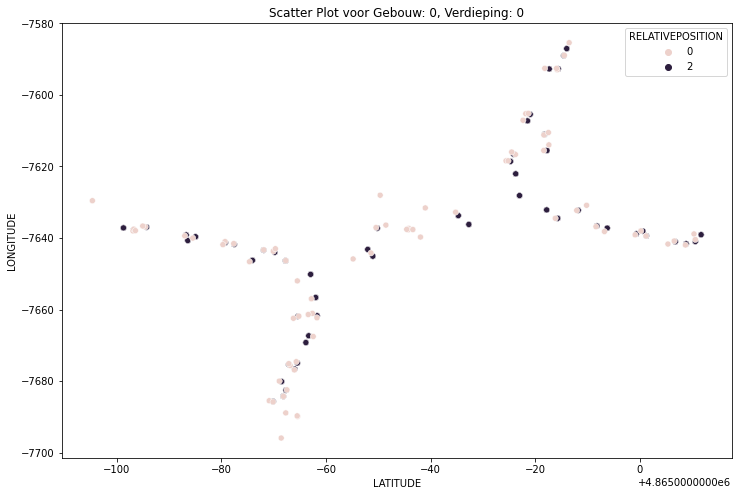

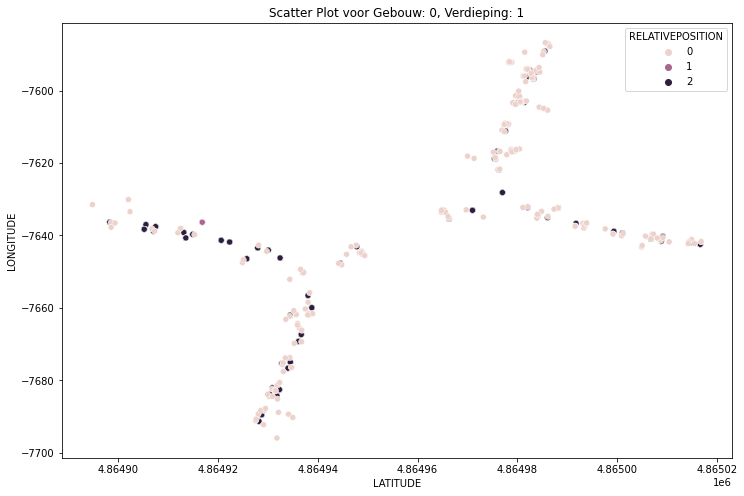

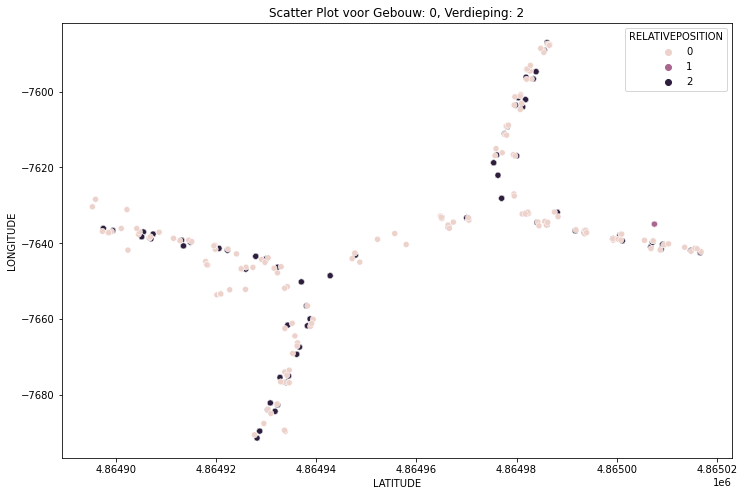

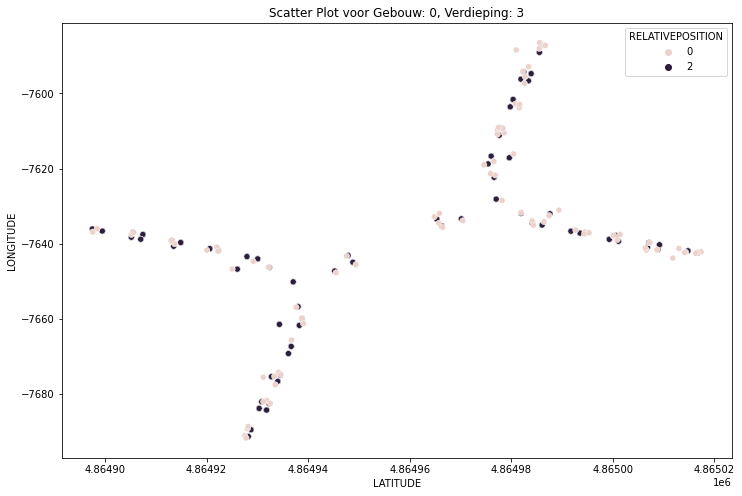

In [59]:
# Geef spreidingsdiagrammen weer voor verschillende gebouwen en verdiepingen
def scatterplot_by_building_floor(building_id, floor_level):
    building_floor_data = df_sorted[(df_sorted['BUILDINGID'] == building_id) & (df_sorted['FLOOR'] == floor_level)]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='LATITUDE', y='LONGITUDE', hue='RELATIVEPOSITION', data=building_floor_data)
    plt.title(f'Scatter Plot voor Gebouw: {building_id}, Verdieping: {floor_level}')
    plt.show()

# Scatter plot for Gebouw_0
scatterplot_by_building_floor(0, 0)
scatterplot_by_building_floor(0, 1)
scatterplot_by_building_floor(0, 2)
scatterplot_by_building_floor(0, 3)

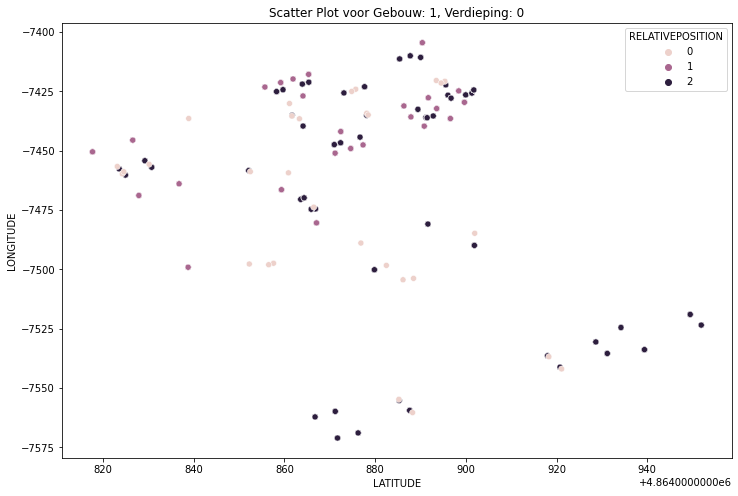

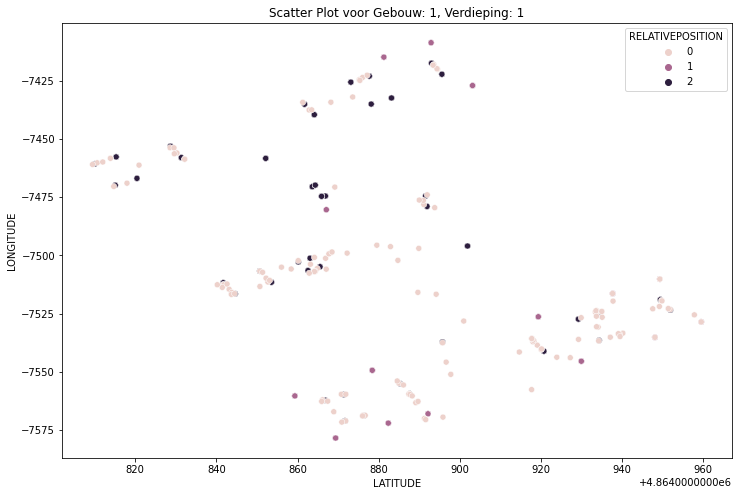

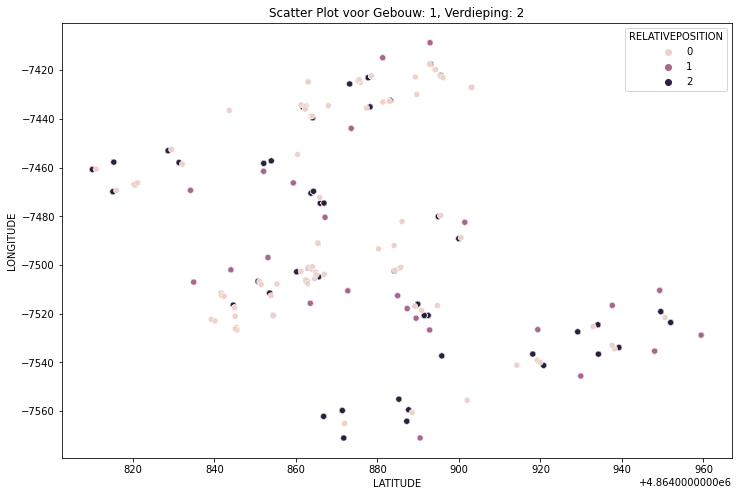

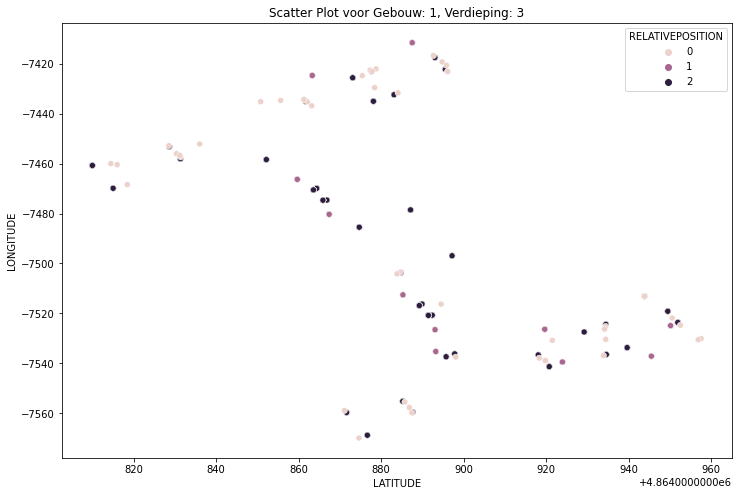

In [60]:
# Scatter plot for Gebouw_1
scatterplot_by_building_floor(1, 0)
scatterplot_by_building_floor(1, 1)
scatterplot_by_building_floor(1, 2)
scatterplot_by_building_floor(1, 3)

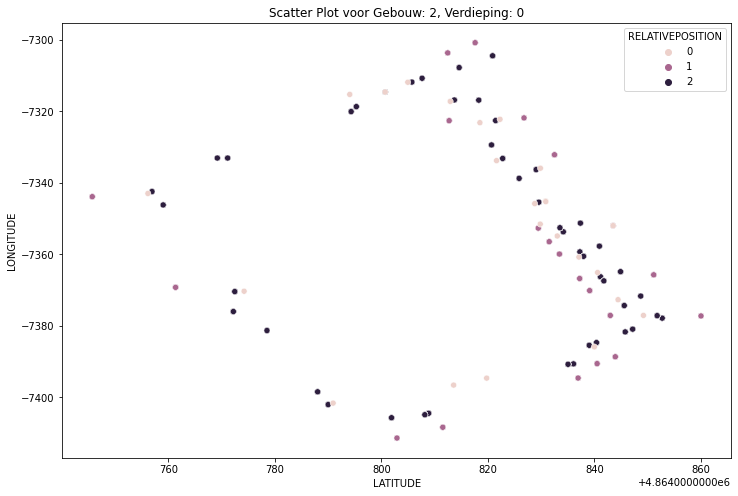

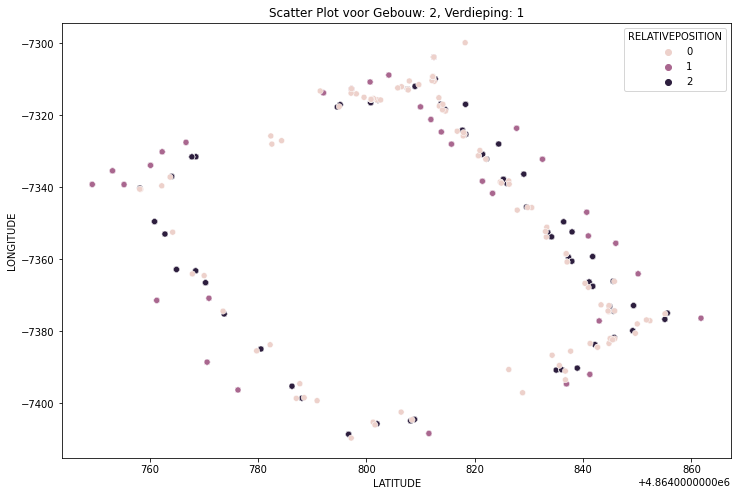

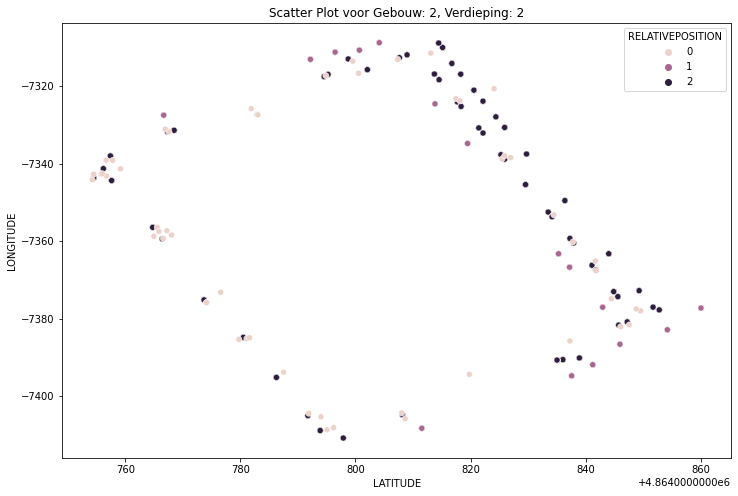

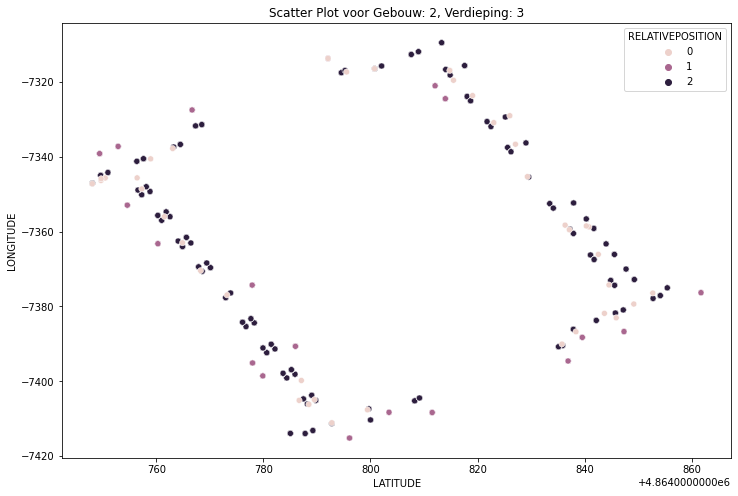

In [61]:
# Scatter plot for Gebouw_2
scatterplot_by_building_floor(2, 0)
scatterplot_by_building_floor(2, 1)
scatterplot_by_building_floor(2, 2)
scatterplot_by_building_floor(2, 3)

## Normalization


In [62]:
# Normaliseer de invoerwaarde x tussen a en b op basis van de gegeven min (xmin) en max (xmax) waarden.
def normalize(x, xmin, xmax, a, b):
   numerator = x - xmin
   denominator = xmax - xmin
   multiplier = b - a
   ans = (numerator/denominator)*multiplier + a
   return ans

### WiFi-Normalization

In [63]:
# Normaliseer de WiFi-signaalsterkte tussen 0,25 en 1,0, exclusief 'geen signaal' (100).
def normalize_wifi(num):
    ans = 0
    num = float(num)
    if math.isclose(num, no_sig, rel_tol=1e-3):
        return 0
    else:
        ans = normalize(num, sig_min, sig_max, tar_min, tar_max)
        return ans

# Pas WiFi-normalisatie toe op trainings- en validatiedatasets
wifi_cells_train = df_train.columns[:519]
wifi_cells_val = df_val.columns[:519]

for i in wifi_cells_train:
    df_train[i] = df_train[i].apply(normalize_wifi)

for i in wifi_cells_val:
    df_val[i] = df_val[i].apply(normalize_wifi)

### Latitude and Longitude Normalization

In [64]:
# Normaliseer de breedtegraad tussen 0 en 1 op basis van de gegeven min- en max-waarden.
def normalize_lat(num):
    num = float(num)
    ans = normalize(num, lat_min, lat_max, tar_min, tar_max)
    return ans

# Normalize longitude between 0 and 1 based on the given min and max values.
def normalize_long(num):
    num = float(num)
    ans = normalize(num, long_min, long_max, tar_min, tar_max)
    return ans

# Pas Latitude-normalisatie toe op trainings- en validatiegegevenssets
df_train["LATITUDE"] = df_train["LATITUDE"].apply(normalize_lat)
df_val["LATITUDE"] = df_val["LATITUDE"].apply(normalize_lat)

# Pas lengtegraadnormalisatie toe op trainings- en validatiegegevenssets
df_train["LONGITUDE"] = df_train["LONGITUDE"].apply(normalize_long)
df_val["LONGITUDE"] = df_val["LONGITUDE"].apply(normalize_long)

### Training values

In [65]:
# Functies en doelvariabelen splitsen
X_train = df_train[wifi_cells_train]
X_val = df_val[wifi_cells_val]

y_train = df_train[["LATITUDE", "LONGITUDE", "BUILDINGID", "FLOOR"]]
y_val = df_val[["LATITUDE", "LONGITUDE", "BUILDINGID", "FLOOR"]]

In [66]:
# Definieer het aantal bakken voor breedte- en lengtegraad
num_bins = 10

# Binning-functie
def bin_values(num, num_bins):
    bin_width = (tar_max - tar_min) / num_bins
    bin_number = int((num - tar_min) / bin_width)
    return bin_number

# Pas binning toe op breedtegraad en lengtegraad
y_train['LATITUDE'] = y_train['LATITUDE'].apply(lambda x: bin_values(x, num_bins))
y_train['LONGITUDE'] = y_train['LONGITUDE'].apply(lambda x: bin_values(x, num_bins))


C:\Users\K1\AppData\Local\Temp\ipykernel_50048\78446547.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['LATITUDE'] = y_train['LATITUDE'].apply(lambda x: bin_values(x, num_bins))
C:\Users\K1\AppData\Local\Temp\ipykernel_50048\78446547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['LONGITUDE'] = y_train['LONGITUDE'].apply(lambda x: bin_values(x, num_bins))


## Clustering
### K-Means Clustering - Location Cluster

In [67]:
# KMeans clustering op basis van building ID, floor, longitude, en latitude
kmeans_input = df[['LATITUDE', 'LONGITUDE', 'BUILDINGID', 'FLOOR']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['location_cluster'] = kmeans.fit_predict(kmeans_input)

c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


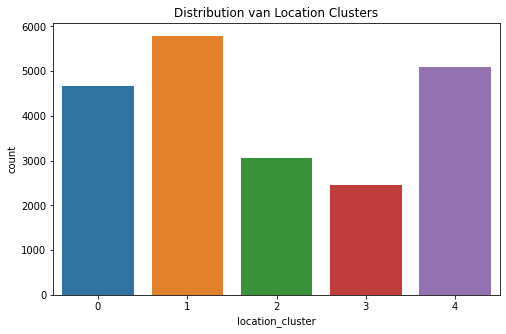

In [68]:
# Toon countplot van locatieclusters
plt.figure(figsize=(8, 5))
sns.countplot(x='location_cluster', data=df)
plt.title("Distribution van Location Clusters")
plt.show()

### Sub-Clustering - Location Cluster inside Cluster

In [ ]:
# Filter de specifieke waarschuwing eruit
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

# KMeans clustering voor sub-clusters binnen alle location cluster
def sub_cluster(row):
    return kmeans.predict([[row['LATITUDE'], row['LONGITUDE'], row['BUILDINGID'], row['FLOOR']]])[0]

df['sub_cluster'] = df.apply(sub_cluster, axis=1)

# Reset warning filters to default (optional)
warnings.resetwarnings()

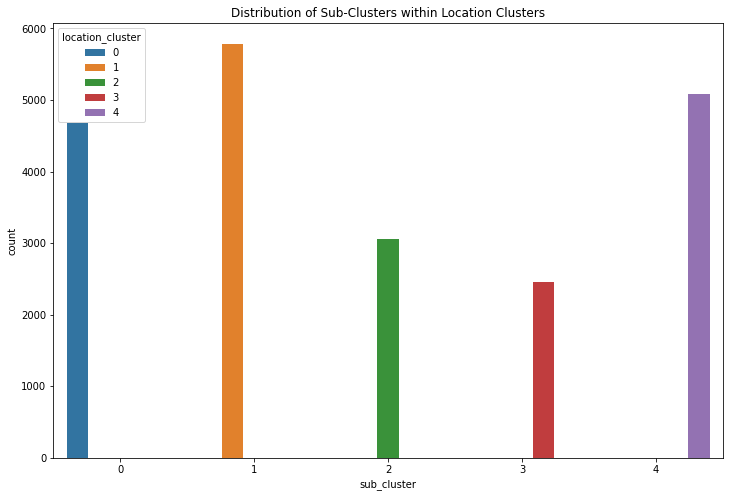

In [70]:
# Display countplot van subclusters binnen elk locatiecluster.
plt.figure(figsize=(12, 8))
sns.countplot(x='sub_cluster', hue='location_cluster', data=df)
plt.title("Distribution of Sub-Clusters within Location Clusters")
plt.show()

In [71]:
# MiniBatchKMeans clustering voor subclusters binnen elk locatiecluster
# Dit heb ik gedaan omdat het sub-clusteren anders veel te lang duurt, vooral met de grootte van de dataset.

def sub_cluster_batch(df_subset):
    kmeans_sub = MiniBatchKMeans(n_clusters=3, random_state=42)
    df_subset['sub_cluster'] = kmeans_sub.fit_predict(df_subset[['LATITUDE', 'LONGITUDE']])
    return df_subset

# Pas subclustering toe op elk locatiecluster met behulp van parallelle verwerking
sub_cluster_labels = Parallel(n_jobs=-1)(delayed(sub_cluster_batch)(group.copy()) for _, group in df.groupby('location_cluster'))

# Voeg de subclusterlabels weer samen met het oorspronkelijke DataFrame
df = pd.concat(sub_cluster_labels)

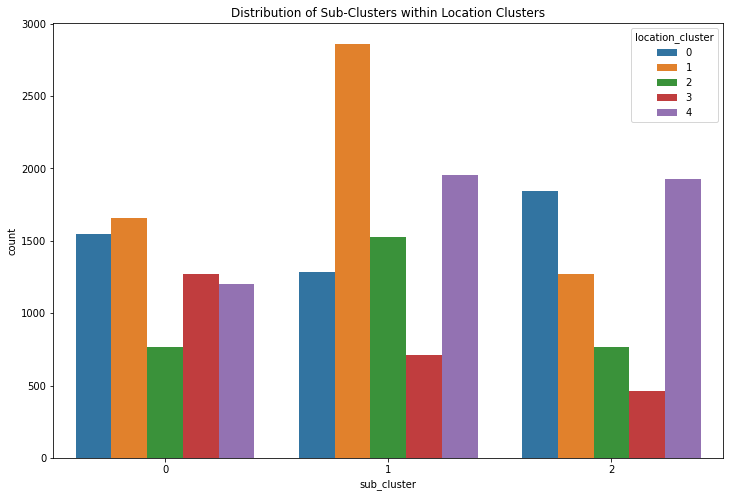

In [72]:
# Display countplot van subclusters binnen elk locatiecluster.
plt.figure(figsize=(12, 8))
sns.countplot(x='sub_cluster', hue='location_cluster', data=df)
plt.title("Distribution of Sub-Clusters within Location Clusters")
plt.show()

## Classification

In [73]:
# Splits de gegevens voor classificatie
X_classification = df[wifi_cells_train]
y_classification = df['sub_cluster']

# Splits de gegevens op in trainings- en validatiesets
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Initialize models
rf_classifier = RandomForestClassifier(random_state=42)
lr_classifier = LogisticRegression(random_state=42)


### Random Forest Classifier

In [74]:
# Train Random Forest Classifier
rf_classifier.fit(X_train_class, y_train_class)


RandomForestClassifier(random_state=42)

### Logistic Regression


In [75]:
# Train Logistic Regression Classifier
lr_classifier.fit(X_train_class, y_train_class)

c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

### Predictions

In [76]:
# Voorspellingen doen op de validatieset
rf_predictions = rf_classifier.predict(X_val_class)
lr_predictions = lr_classifier.predict(X_val_class)

### Evaluate

In [77]:
# Evalueer de prestaties van elke classificator
print("Random Forest Classifier:")
print(classification_report(y_val_class, rf_predictions))

print("\nLogistic Regression Classifier:")
print(classification_report(y_val_class, lr_predictions))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1288
           1       0.99      0.97      0.98      1659
           2       0.97      0.96      0.96      1263

    accuracy                           0.97      4210
   macro avg       0.97      0.97      0.97      4210
weighted avg       0.97      0.97      0.97      4210


Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1288
           1       0.93      0.90      0.92      1659
           2       0.85      0.87      0.86      1263

    accuracy                           0.89      4210
   macro avg       0.89      0.89      0.89      4210
weighted avg       0.89      0.89      0.89      4210



### Ensemble using VotingClassifier

In [78]:
# Ensemble: maak een Voting Classifier
voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('lr', lr_classifier)], voting='hard')

# Train de Voting Classifier op de trainingsset
voting_classifier.fit(X_train_class, y_train_class)

# Maak voorspellingen met behulp van het ensemble
ensemble_predictions = voting_classifier.predict(X_val_class)



c:\Users\K1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
# Evalueer de prestaties van de ensembleclassificator
print("\nEnsemble (Voting Classifier):")
print(classification_report(y_val_class, ensemble_predictions))


Ensemble (Voting Classifier):
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1288
           1       0.95      0.95      0.95      1659
           2       0.97      0.86      0.91      1263

    accuracy                           0.93      4210
   macro avg       0.93      0.93      0.93      4210
weighted avg       0.94      0.93      0.93      4210



## Prediction

In [80]:
# Gebruik de getrainde modellen voor voorspelling
rf_predictions = rf_classifier.predict(X_val_class)
lr_predictions = lr_classifier.predict(X_val_class)
ensemble_predictions = voting_classifier.predict(X_val_class)

In [81]:
# Maak een DataFrame om voorspellingen op te slaan
predictions_df = pd.DataFrame({
    'USERID': X_val_class.index,
    'RandomForest_Prediction': rf_predictions,
    'LogisticRegression_Prediction': lr_predictions,
    'Ensemble_Prediction': ensemble_predictions
})

# Geef de voorspellingen weer
print("Voorspellingen voor de volgende locatie:")
print(predictions_df.head())

Voorspellingen voor de volgende locatie:
   USERID  RandomForest_Prediction  LogisticRegression_Prediction  \
0    2626                        1                              1   
1   19275                        1                              2   
2   10883                        1                              1   
3    9106                        2                              2   
4   16203                        0                              0   

   Ensemble_Prediction  
0                    1  
1                    1  
2                    1  
3                    2  
4                    0  


In [82]:
# voeg voorspellingen samen met andere relevante gegevens, bijvoorbeeld gebouw, verdieping, enz.
predictions_with_data = pd.merge(predictions_df, df[['USERID', 'BUILDINGID', 'FLOOR', 'sub_cluster']], on='USERID')

# Geef voorspellingen weer met aanvullende gegevens
print("\nVoorspellingen met aanvullende gegevens:")
print(predictions_with_data.head())


Voorspellingen met aanvullende gegevens:
   USERID  RandomForest_Prediction  LogisticRegression_Prediction  \
0       0                        2                              2   
1       0                        2                              2   
2       0                        2                              2   
3       0                        2                              2   
4       0                        2                              2   

   Ensemble_Prediction  BUILDINGID  FLOOR  sub_cluster  
0                    2           2      2            0  
1                    2           2      3            1  
2                    2           2      2            1  
3                    2           2      2            1  
4                    2           2      2            1  
